# Multilayer Perceptrons in PyTorch

Recall that before, we mapped our inputs directly onto our outputs through a single linear transformation.

$$\hat{y} = \mbox{softmax}(W \boldsymbol{x} + b)$$

Graphically, we could depict the model like this:

<center>![](./images/simple-softmax-net.png)</center>

If our labels really were related to our input data by an approximately linear function, then this approach might be adequate. But *linearity is a strong assumption*. Linearity means that given an output of interest, for each input, increasing the value of the input should either drive the value of the output up or drive it down, irrespective of the value of the other inputs.

Imagine the case of classifying cats and dogs based on black and white images. That’s like saying that for each pixel, increasing its value either increases the probability that it depicts a dog or decreases it. That’s not reasonable. After all, the world contains both black dogs and black cats, and both white dogs and white cats.

Teasing out what is depicted in an image generally requires allowing more complex relationships between our inputs and outputs, considering the possibility that our pattern might be characterized by interactions among the many features. In these cases, linear models will have low accuracy. We can model a more general class of functions by incorporating one or more hidden layers. The easiest way to do this is to stack a bunch of layers of neurons on top of each other. Each layer feeds into the layer above it, until we generate an output. This architecture is commonly called a “multilayer perceptron”. With an MLP, we’re going to stack a bunch of layers on top of each other.

$$h_1 = \phi(W_1\boldsymbol{x} + b_1)$$
$$h_2 = \phi(W_2\boldsymbol{h_1} + b_2)$$
$$...$$
$$h_n = \phi(W_n\boldsymbol{h_{n-1}} + b_n)$$

Note that each layer requires its own set of parameters. For each hidden layer, we calculate its value by first applying a linear function to the acivations of the layer below, and then applying an element-wise nonlinear activation function. Here, we’ve denoted the activation function for the hidden layers as $\phi$. Finally, given the topmost hidden layer, we’ll generate an output. Because we’re still focusing on multiclass classification, we’ll stick with the softmax activation in the output layer.

$$\hat{y} = \mbox{softmax}(W_y \boldsymbol{h}_n + b_y)$$

Graphically, a multilayer perceptron could be depicted like this:

<center>![](./images/multilayer-perceptron.png)</center>

Multilayer perceptrons can account for complex interactions in the inputs because the hidden neurons depend on the values of each of the inputs. It’s easy to design a hidden node that that does arbitrary computation, such as, for instance, logical operations on its inputs. And it’s even widely known that multilayer perceptrons are universal approximators. That means that even for a single-hidden-layer neural network, with enough nodes, and the right set of weights, it could model any function at all! Actually learning that function is the hard part. And it turns out that we can approximate functions much more compactly if we use deeper (vs wider) neural networks.

In [2]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare CIFAR10 dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Define the model with *nn.Module*

If we compose a multi-layer network but use only linear operations, then our entire network will still be a linear function. To give our model the capacity to capture nonlinear functions, we’ll need to interleave our linear operations with activation functions. In this case, we’ll use the rectified linear unit (ReLU):

In [4]:
n_in = image_size[0] * image_size[1] * image_size[2]
n_h1 = 256
n_o = 10

class MultilayerPerceptron(nn.Module):
    def __init__(self, **kwargs):
        super(MultilayerPerceptron, self).__init__(**kwargs)
        self.dense_1 = T.nn.Linear(n_in, n_h1)
        self.dense_2 = T.nn.Linear(n_h1, n_o)
        
    def forward(self, x):
        x = x.view(-1, n_in)
        # apply rectified linear unit (which is non-linear!)
        x = F.relu(self.dense_1(x))
        x = self.dense_2(x)
        return x

In [5]:
net = MultilayerPerceptron()
net.to(device)

MultilayerPerceptron(
  (dense_1): Linear(in_features=3072, out_features=512, bias=True)
  (dense_2): Linear(in_features=512, out_features=10, bias=True)
)

## Setup the loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training and Evaluation

In [7]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 33):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Train Acc. => 37.894% | Train Loss => 1.7799402134432216
Test Acc. => 43.830000000000005% | Test Loss => 1.617559383471553

Train Acc. => 45.512% | Train Loss => 1.5630083444861365
Test Acc. => 46.5% | Test Loss => 1.5197934434055902

Train Acc. => 48.92% | Train Loss => 1.473174580075538
Test Acc. => 48.699999999999996% | Test Loss => 1.4605284797878693

Train Acc. => 51.486% | Train Loss => 1.4053743961371448
Test Acc. => 50.4% | Test Loss => 1.4199186717740262

Train Acc. => 53.480000000000004% | Train Loss => 1.347788511638983
Test Acc. => 51.239999999999995% | Test Loss => 1.3938687020978227

Train Acc. => 55.346% | Train Loss => 1.2993102406967318
Test Acc. => 52.31% | Test Loss => 1.3684557775339

Train Acc. => 57.02199999999999% | Train Loss => 1.2546785040993913
Test Acc. => 51.94% | Test Loss => 1.358425040024157

Train Acc. => 58.37% | Train Loss => 1.2141954072453773
Test Acc. => 52.81% | Test Loss => 1.3449796394418223

Train Acc. => 59.754% | Train Loss => 1.176033565842

## Conclusion

Nice! With just two hidden layers containing 256 hidden nodes, respectively, we can achieve over 54% accuracy on this task.

In [8]:
import matplotlib.pyplot as plt

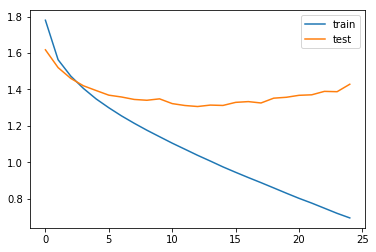

In [9]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

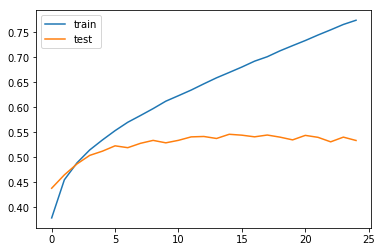

In [10]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()